In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg


In [ ]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
#as provided in ppt. base model
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
# Spatial size of training images. All images will be resized to this size using a transformer
IMAGE_SIZE = 64
# Number of channels in the training images. For color images this is 3
CHANNELS_IMG = 3  
# Size of z latent vector (i.e. size of generator input)
NOISE_DIM = 100
NUM_EPOCHS = 50
# Size of feature maps in discriminator
FEATURES_DISC = 64 
# Size of feature maps in generator
FEATURES_GEN = 64 

weight_clip = 0.01
criticItr = 5


Device: cuda


In [ ]:
#loading the dataset
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
##Dataset for all classes###
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# ###Subset of the dataset for airplane###
# subset_indices=[]
# idx = dataset.class_to_idx['bird']

# for i in range(len(dataset)):
#     if dataset[i][1] == idx:
#         subset_indices.append(i)
# subset_indices = subset_indices[:int(0.6 * len(subset_indices))]
# dataset_subset = Subset(dataset, subset_indices)

In [ ]:
# dataloader = torch.utils.data.DataLoader(dataset_subset, batch_size=BATCH_SIZE,
#                                          shuffle=True, num_workers=2)

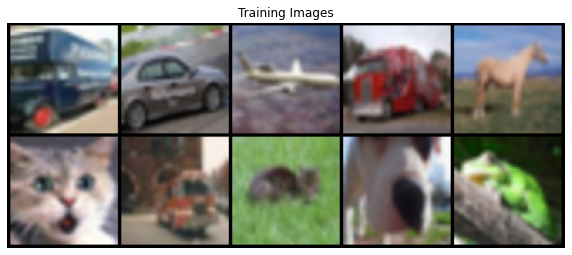

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10],nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      #out=128,k=5,s=2,p=1
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  #out=256,k=5,s=2,p=1
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  #out=512,k=5,s=2,p=1
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine =True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            #Gnet(in_channels, out_channels, kernel_size, stride, padding)
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
#Intitating instances
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [ ]:
optimGenerator = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
optimDiscriminator = optim.RMSprop(disc.parameters(), lr=LEARNING_RATE)

In [ ]:
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
step = 0

In [ ]:
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [ ]:
#FID implemention#
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value


In [ ]:
  #training block
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []

print("!!Training Started!!")
# start timing
time_start = time.time() 
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    
    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        batch = real.shape[0]
        # print(batch == BATCH_SIZE)

        # Train Critic(Discriminator): max E[critic(real)] - E[critic(fake)]
        for i in range (criticItr):
            noise = torch.randn(batch, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise) #genrator img data
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimDiscriminator.step()

            # clip critic weights between -0.01, 0.01
            for param in disc.parameters():
                param.data.clamp_(-weight_clip, weight_clip)


        ### Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        output = disc(fake).reshape(-1)
        loss_gen = -torch.mean(output) 
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

#         # Print losses occasionally and print to tensorboard
#         if batch_idx % 100 == 0:
#             print(
#                 f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
#                   Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}",end = '\r', flush=True
#             )
        #saving the losses for every 100 batch
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())
#         DiscLossP.append(-(loss_critic.detach().cpu()))
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake[:10],nrow=5, padding=2, normalize=True))
            
        iters += 1
        
    #Cal. FID
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    
    if epoch%5 == 0:
        print( f'\nEpoch [{epoch}/{NUM_EPOCHS}]Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f} FID:{fretchet_dist:.3f} ')
    
    
    #Saving Generated image/epoch     
    images = gen(fixed_noise)
    utils.save_image(images.detach(),'Results/WGAN_FAKE/WGAN50_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
#     real = data[0].to(device)
    utils.save_image(real.detach(),'Results/WGAN_REAL/WGAN50_epoch_%03d.png' % (epoch), normalize = True)
        
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))

!!Training Started!!

Epoch [5/50]Batch 1562/1563                 Loss Discriminator: -0.657, loss Generator: 0.530 FID:273.106 

Epoch [10/50]Batch 1562/1563                 Loss Discriminator: -0.493, loss Generator: 0.139 FID:266.161 

Epoch [15/50]Batch 1562/1563                 Loss Discriminator: -0.651, loss Generator: 0.232 FID:278.893 

Epoch [20/50]Batch 1562/1563                 Loss Discriminator: -0.558, loss Generator: 0.162 FID:270.862 

Epoch [30/50]Batch 1562/1563                 Loss Discriminator: -0.469, loss Generator: 0.010 FID:285.730 

Epoch [35/50]Batch 1562/1563                 Loss Discriminator: -0.513, loss Generator: 0.594 FID:268.784 

Epoch [40/50]Batch 1562/1563                 Loss Discriminator: -0.586, loss Generator: 0.063 FID:276.773 

Epoch [45/50]Batch 1562/1563                 Loss Discriminator: -0.246, loss Generator: 0.228 FID:266.389 

Epoch [50/50]Batch 1562/1563                 Loss Discriminator: -0.124, loss Generator: 0.208 FID:286.188 

In [ ]:
np.save('Results/Loss_Data/WGAN_GLoss', GenLoss) 
np.save('Results/Loss_Data/WGAN_DLoss', DiscLoss) 
GenLoss = np.load('Results/Loss_Data/WGAN_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/WGAN_DLoss.npy')

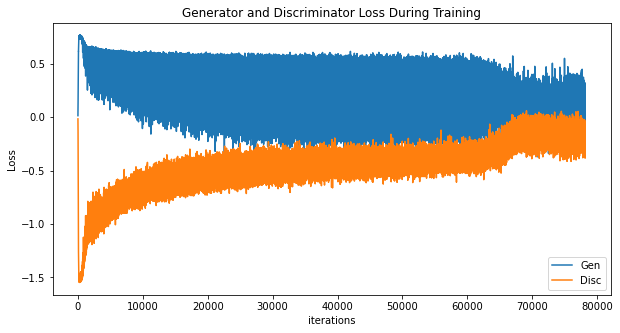

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
np.mean(GenLoss),np.mean(DiscLoss)

(0.25855953, -0.47264114)

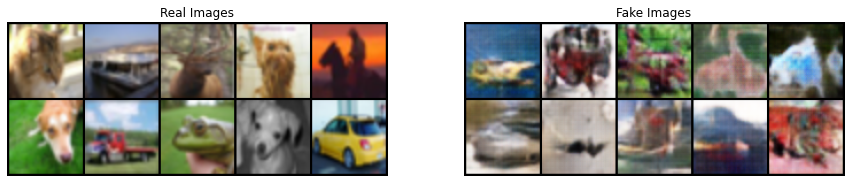

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
# plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10],nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
# plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.imshow(np.transpose(utils.make_grid(img_list[-1].to(device),nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
fig.savefig('Results/WGAN_BEST_FAKE_32.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

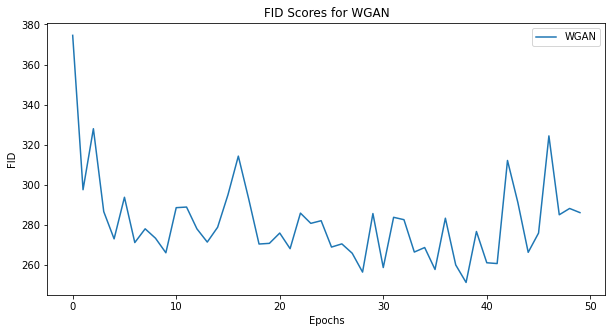

In [ ]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for WGAN")
plt.plot(FID_list,label="WGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()

In [ ]:
np.save('Results/FID_score/WGAN_FID', FID_list) 

In [ ]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-1]

(251.3710760218363, 374.5848416446571, 281.51516925367105, 286.18797316330983)